# Wstęp
**Logika rozmyta** to metoda, która pozwala na opisywanie zjawisk, które nie są zero jedynkowe. W przypadku klasycznej logiki binarnej przyporządkowanie do zbioru było prawda/fałsz, natomiast przy rozmytej możemy to przyporządkowanie ustalić w zakresie od 0 do 1. Najprostszym i zarazem najlepszym przykładem takiej funkcji przynależności jest temperatura. Każdy temperaturę interpretuje w inny sposób. Dla niektórych 20 stopni to ciepło a dla innych to taka średnia i żeby uznać, że jest ciepło potrzebują minimum 25 stopni. Aby skutecznie wnioskować z funkcji przynależności, potrzebujemy pewnego zestawu reguł w formacie "Jeżeli WARUNKI to EFEKT". Na podstawie tych reguł możemy dokonywać wnioskowania i obliczać wartość wyjściową.

# Zadanie 1
Proszę zaprojektować rozmyty system sterowania automatycznym podlewaniem grządki. Grządka ma 3m^2, a system podlewania może nawadniać w tempie maksymalnie 25l/dziennie, podczas, gdy zalecana ilość wody dla "zwyczajnych" warunków dla grządki w takim rozmiarze to 10l/dziennie.

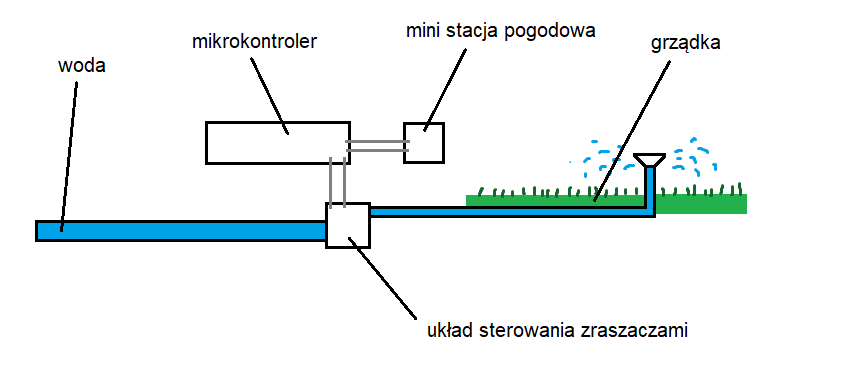

System jest sterowany elektronicznie i jest do niego podłączony higrometr (mierzący wilgotność względną w zakresie od 0% do 100%) i termometr. Temperatury są mierzone wyłącznie za dnia i znajdują się w zakresie 15°C - 35°C.Proszę zaprojektować układ rozmytego sterowania, układając reguły na podstawie następującej tabelki:

|                 | Sucho             | Przeciętnie                | Mokro      |
|-----------------|----------------------|----------------------|------------------|
| **Chłodno**     | Podlewaj średnio        | Podlewaj średnio     | Podlewaj mało    |
| **Ciepło**      | Podlewaj dużo        | Podlewaj średnio        | Podlewaj mało |
| **Gorąco**      | Podlewaj dużo | Podlewaj dużo        | Podlewaj średnio    |

Proszę samodzielnie zaproponować rozmyte funkcje przynależności i narysować je na wykresach. Proszę przedstawić heatmapę wynikowej funkcji ilości wody używanej dziennie w zależności od wilgotności i temperatury ukrytej w mechanizmie sterowania.

Niezbędne importy

In [24]:
import numpy as np
import skfuzzy as fuzz
import matplotlib.pyplot as plt
from skfuzzy import control as ctrl
import seaborn as sns
import pandas as pd

Tworzymy własne rozmyte funkcje przynależności i je wyświetlamy **fuzyfikacja**

/Users/maciek_gangus/PycharmProjects/MIOpack/.venv/lib/python3.9/site-packages/skfuzzy/control/fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


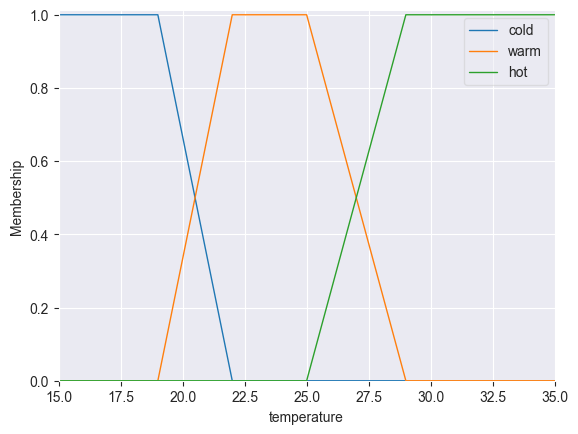

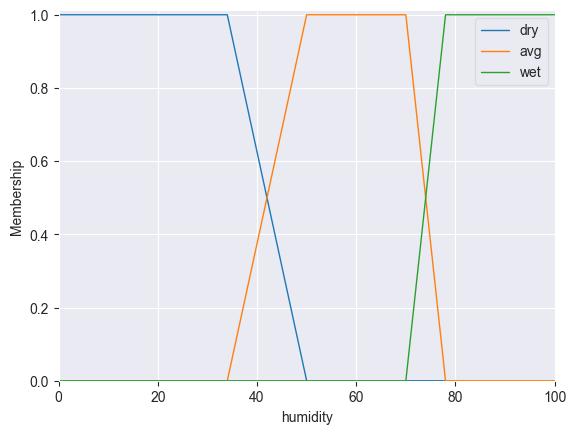

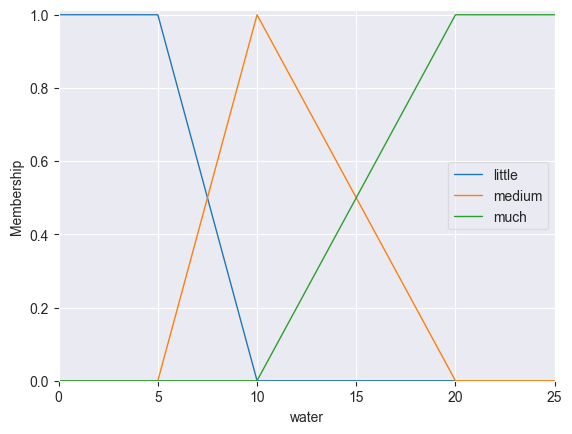

In [25]:
temperature = ctrl.Antecedent(np.arange(15, 35.1, 0.1), "temperature")
humidity = ctrl.Antecedent(np.arange(0, 101, 1), "humidity")
water = ctrl.Consequent(np.arange(0, 25.1, 0.1), "water")

temperature["cold"] = fuzz.trapmf(temperature.universe, [15, 15, 19, 22])
temperature["warm"] = fuzz.trapmf(temperature.universe, [19, 22, 25, 29])
temperature["hot"] = fuzz.trapmf(temperature.universe, [25, 29, 35.1, 35.1])

humidity["dry"] = fuzz.trapmf(humidity.universe, [0, 0, 34, 50])
humidity["avg"] = fuzz.trapmf(humidity.universe, [34, 50, 70, 78])
humidity["wet"] = fuzz.trapmf(humidity.universe, [70, 78, 101, 101])

water["little"] = fuzz.trapmf(water.universe, [0, 0, 5, 10])
water["medium"] = fuzz.trimf(water.universe, [5, 10, 20])
water["much"] = fuzz.trapmf(water.universe, [10, 20, 25, 25])

temperature.view()
humidity.view()
water.view()

Dodajemy reguły zgodnie z rozpiską w zadaniu **wnioskowanie**

In [27]:
rule1 = ctrl.Rule(temperature["cold"] & (humidity["dry"] | humidity["avg"]), water["medium"])
rule2 = ctrl.Rule(temperature["cold"] & humidity["wet"], water["little"])

rule3 = ctrl.Rule(humidity["dry"] & (temperature["warm"] | temperature["hot"]), water["much"])
rule4 = ctrl.Rule(temperature["warm"] & humidity["avg"], water["medium"])
rule5 = ctrl.Rule(temperature["warm"] & humidity["wet"], water["little"])

rule6 = ctrl.Rule(temperature["hot"] & humidity["avg"], water["much"])
rule7 = ctrl.Rule(temperature["hot"] & humidity["wet"], water["medium"])

Tworzymy system kontroli i na jego podstawie model

In [28]:
control_system = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule7])
model = ctrl.ControlSystemSimulation(control_system)

Rysujemy heatmapę, aby zademonstrować wyniki modeli do wszystkich możliwych kombinacji **defuzyfikacja**

<Axes: xlabel='humidity', ylabel='temperature'>

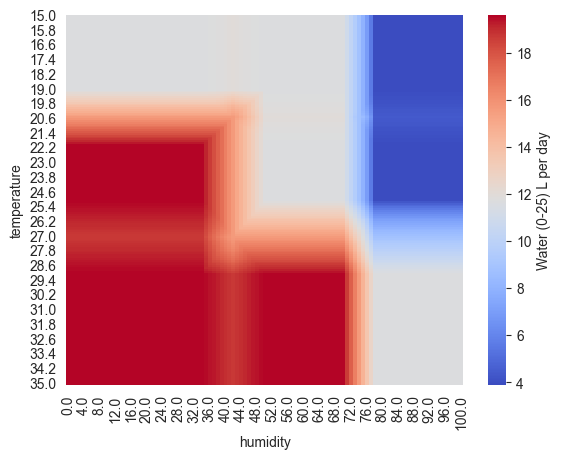

In [29]:
temp_grid, humidity_grid = np.meshgrid(np.arange(15,35.1,0.1), np.arange(0,101,1))
test_points = np.transpose(np.vstack((np.ravel(temp_grid),np.ravel(humidity_grid))))

model.input["temperature"] = test_points[:,0]
model.input["humidity"] = test_points[:,1]
model.compute()

test_points = np.concatenate((test_points, model.output["water"].reshape(-1,1)), axis=1)
df = pd.DataFrame(test_points, columns=["temperature", "humidity", "water"])
df["temperature"] = df["temperature"].round(1)

sns.heatmap(df.pivot(index="temperature", columns="humidity", values="water"), cmap="coolwarm", cbar_kws={"label": "Water (0-25) L per day"})

# Wnioski
Wyświetlona heatmapa obrazuje, w jaki sposób poziom nawadniania będzie się zmieniał w zależności od wilgotności wody oraz temperatury powietrza. Sytuację, które tutaj mocno się wyróżniają to:
- Gdy mamy na dworze więcej niż 30 stopni i poziom wilgotności jest niższy niż 70% to wtedy nawadnianie rośnie do 19 litrów dziennie.
- Jeśli poziom wilgotności jest wyższy niż 70% to nasze nawadnianie znacząco maleje. Jeśli temperatura <25 to 4 l/dzień >25 11 l/dzień

# Zadanie 2
Proszę zaproponować rozmyty system wnioskowania dla dowolnego wybranego (ale różnego od poruszanych dotychczas) problemu. Proszę wziąć pod uwagę co najmniej trzy zmienne wejściowe i każdą zmienną podzielić na co najmniej trzy zbiory rozmyte. Proszę stworzyć co najmniej 5 reguł i skomentować wyniki.

W niniejszym zadaniu zaprojektowano rozmyty system wnioskowania, który na podstawie zmiennych wejściowych (**wzrost**, **zarobki**, **wiek**) określa **szansę na swipe na tinderze**. 
Każda zmienna wejściowa została podzielona zbiory rozmyte.
- Wzrost (niski, średni, wysoki, bardzo wysoki)
- Zarobki (bardzo niskie, niskie, średnie, wysokie)
- Wiek (młody, średni, dojrzały) 



/Users/maciek_gangus/PycharmProjects/MIOpack/.venv/lib/python3.9/site-packages/skfuzzy/control/fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


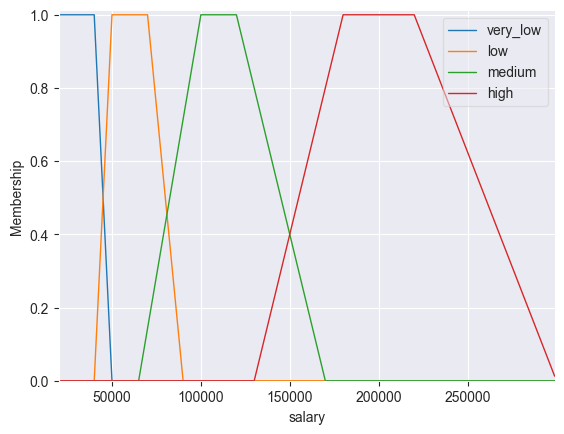

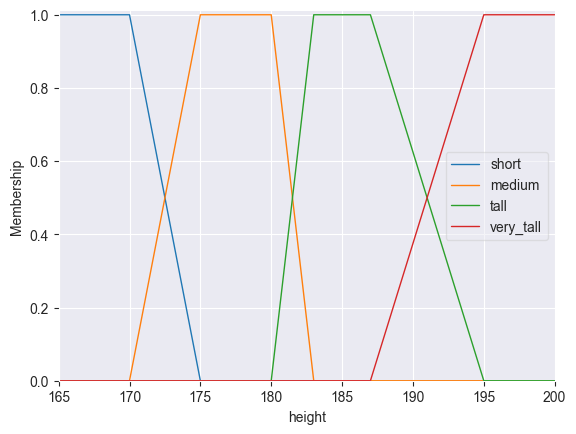

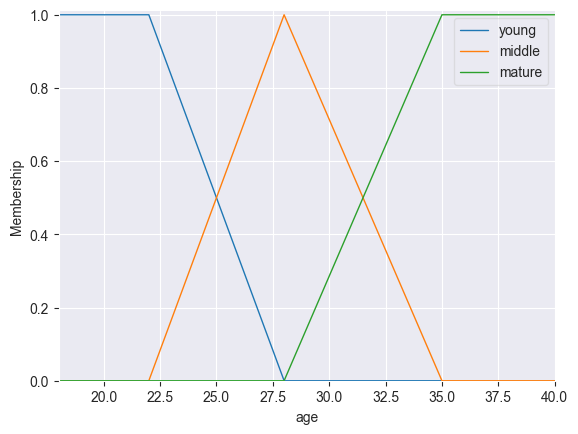

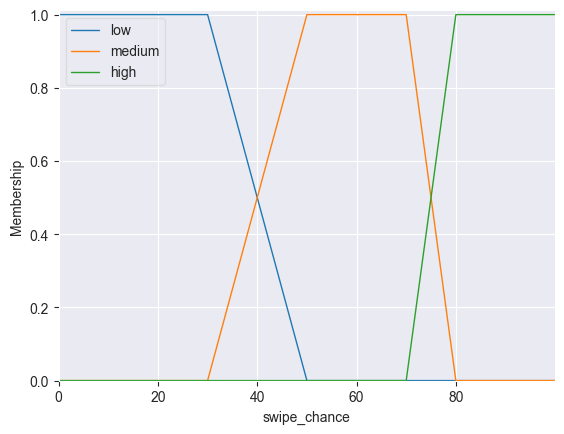

In [30]:
height = ctrl.Antecedent(np.arange(165, 201, 1), 'height')
salary = ctrl.Antecedent(np.arange(20_000, 300_000, 1000), 'salary')
age = ctrl.Antecedent(np.arange(18, 41, 1), 'age')
swipe_chance = ctrl.Consequent(np.arange(0, 100, 0.1), 'swipe_chance')

height['short'] = fuzz.trapmf(height.universe, [165, 165, 170, 175])  # Krótki
height['medium'] = fuzz.trapmf(height.universe, [170, 175, 180, 183])  # Średni
height['tall'] = fuzz.trapmf(height.universe, [180, 183, 187, 195])  # Wysoki
height['very_tall'] = fuzz.trapmf(height.universe, [187, 195, 200, 200])  # Bardzo wysoki

salary['very_low'] = fuzz.trapmf(salary.universe, [20000, 20000, 40000, 50000])  # Bardzo niskie
salary['low'] = fuzz.trapmf(salary.universe, [40000, 50000, 70000, 90000])  # Niskie
salary['medium'] = fuzz.trapmf(salary.universe, [65000, 100000, 120000, 170000])  # Średnie
salary['high'] = fuzz.trapmf(salary.universe, [130000, 180000, 220000, 300000])  # Wysokie

age['young'] = fuzz.trapmf(age.universe, [18, 18, 22, 28])  # Młody
age['middle'] = fuzz.trimf(age.universe, [22, 28, 35])  # Średni
age['mature'] = fuzz.trapmf(age.universe, [28, 35, 40, 40])  # Dojrzały

swipe_chance['low'] = fuzz.trapmf(swipe_chance.universe, [0, 0, 30, 50])  # Niska
swipe_chance['medium'] = fuzz.trapmf(swipe_chance.universe, [30, 50, 70, 80])  # Średnia
swipe_chance['high'] = fuzz.trapmf(swipe_chance.universe, [70, 80, 100, 100])  # Wysoka

salary.view()
height.view()
age.view()
swipe_chance.view()



Tworzymy reguły:
- Niskie zarobki lub niski wzrost = niska szansa
- Wysokie zarobki lub wysoki wzrost = wysoka szansa
- Młody wiek lub średnie zarobki = średnia szansa
- Wysokie zarobki i średni wiek = wysoka szansa
- Bardzo niskie zarobki i dojrzały wiek = niska szansa
- Bardzo wysoki wzrost lub średnie zarobki = średnia szansa

Reguły zostały stworzone głównie na podstawie intuicji i ogólnych założeń dotyczących wpływu poszczególnych zmiennych na szansę na swipe. Nie posiłkowałem się w tym żadnymi konkretnymi danymi lub statystykami. 

In [ ]:
rule1 = ctrl.Rule(salary['low'] | height['short'], swipe_chance['low'])  
rule2 = ctrl.Rule(salary['high'] | height['tall'], swipe_chance['high'])  
rule3 = ctrl.Rule(age['young'] | salary['medium'], swipe_chance['medium'])  
rule4 = ctrl.Rule(salary['high'] & age['middle'], swipe_chance['high'])  
rule5 = ctrl.Rule(salary['very_low'] & age['mature'], swipe_chance['low'])  
rule6 = ctrl.Rule(height['very_tall'] | salary['medium'], swipe_chance['medium'])  

control_system = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6])

model = ctrl.ControlSystemSimulation(control_system)

Narysowano heatmapy w zależności od wieku oraz wzrostu ustalając przy tym stałe zarobki.

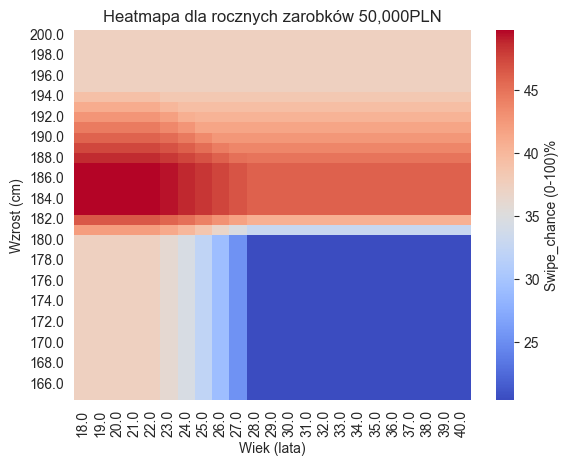

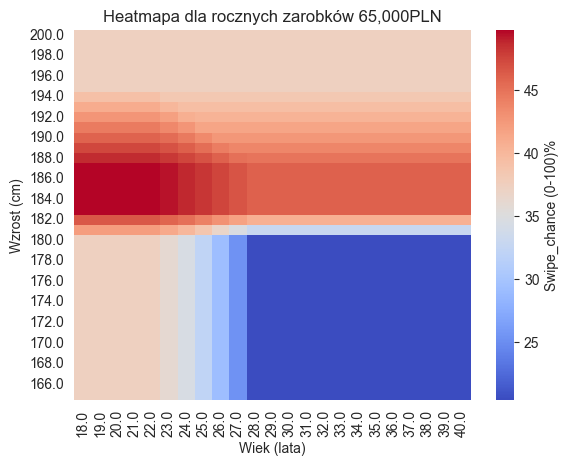

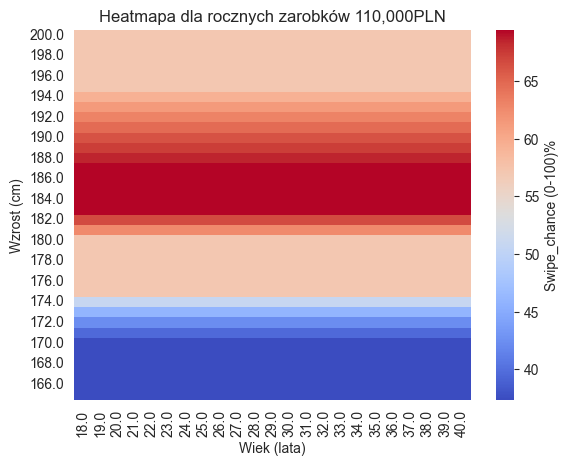

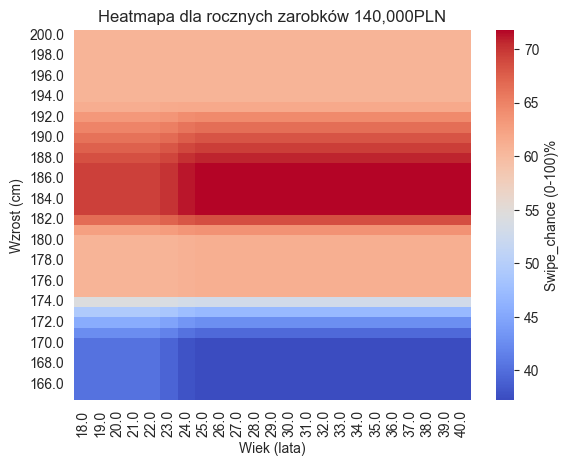

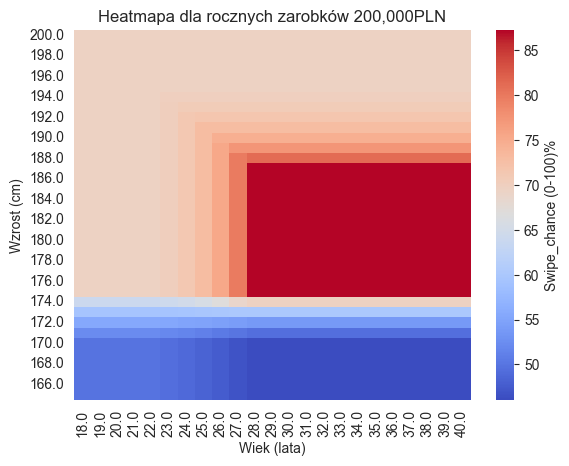

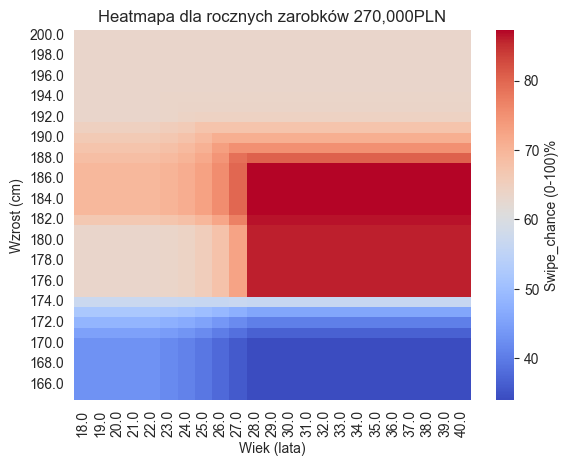

In [33]:
height_grid, age_grid = np.meshgrid(np.arange(165, 201, 1), np.arange(18, 41, 1))
test_points = np.transpose(np.vstack((np.ravel(height_grid),np.ravel(age_grid))))
salary_values = [50_000, 65_000, 110_000, 140_000, 200_000, 270_000]
for salary_value in salary_values:
    results=[]
    for point in test_points:
        h, a = point
        model.input['height'] = h
        model.input['age'] = a
        model.input['salary'] = salary_value
        model.compute()
        results.append(model.output['swipe_chance'])
    
    results = np.array(results)
    data = np.concatenate((test_points, results.reshape(-1, 1)), axis=1)
    df = pd.DataFrame(data=data, columns=['height', 'age', 'swipe_chance'])
    
    pivot = df.pivot(index='height', columns='age', values='swipe_chance')
    pivot = pivot.sort_index(ascending=False)
    sns.heatmap(pivot, cmap="coolwarm", cbar_kws={"label": "Swipe_chance (0-100)%"})
    plt.title(f"Heatmapa dla rocznych zarobków {salary_value:,}PLN")
    plt.xlabel('Wiek (lata)')
    plt.ylabel('Wzrost (cm)')
   

    # Wyświetlanie wykresu
    plt.show()


# Wnioski
Według mnie model całkiem nieźle przewidział szansę na swipe. Na pierwszy rzut oka widać, że im większe zarobki, tym większa szansa co uznałem za podstawową korelacją. Dodatkowo widać również, że wzrost odgrywa dużą rolę i nawet mimo wysokich zarobków wraz z jego spadkiem szansa na swipe również drastycznie spada. Co więcej, można zauważyć, że model premiuje osoby młodsze i przyporządkowuje im wyższą szansę.